**This notebook is devoted to find the optimal cut in the (PMT-summed) waveform to kill noise and perform zero suppression.**

In [1]:
from __future__ import print_function
import tables as tb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.sensorFunctions as sns
import Core.fitFunctions as fit
import Core.tblFunctions as tbl

import Database.loadDB as DB

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 26/11/2016 at 19:06:01.


In [2]:
try:
    h5f.close()
except:
    pass

In [3]:
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/DATA/test_run_2978.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/DATA/test_run_2978.h5 (File) ''
Last modif.: 'Sat Nov 26 18:54:35 2016'
Object Tree: 
/ (RootGroup) ''
/Deconvolution (Group) ''
/Deconvolution/BL (EArray(91, 12, 3), shuffle, zlib(4)) ''
/Deconvolution/Parameters (Table(1,)) 'Deconvolution parameters'
/RD (Group) ''
/RD/pmtblr (EArray(91, 12, 48000), zlib(4)) ''
/RD/pmtcwf (EArray(91, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(91, 12, 48000), zlib(4)) ''
/RD/sipmrwf (EArray(91, 1792, 1200), zlib(4)) ''
/Run (Group) ''
/Run/events (Table(91,)) ''
/Run/runInfo (Table(1,)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''
/ZS (Group) ''
/ZS/BLR (EArray(91, 12, 48000), shuffle, zlib(4)) ''
/ZS/PMT (EArray(91, 12, 48000), shuffle, zlib(4)) ''
/ZS/SiPM (EArray(91, 1792, 1200), shuffle, zlib(4)) ''



In [5]:
pmtblr   = h5f.root.RD.pmtblr
pmtcwf   = h5f.root.RD.pmtcwf
pmtzs   = h5f.root.ZS.PMT

pmtdf    = DB.DataPMT()
sipmdf   = DB.DataSiPM()
adc_to_pes = abs(1.0/pmtdf["adc_to_pes"].reshape(pmtcwf.shape[1], 1))

(-0.5, 0.5)

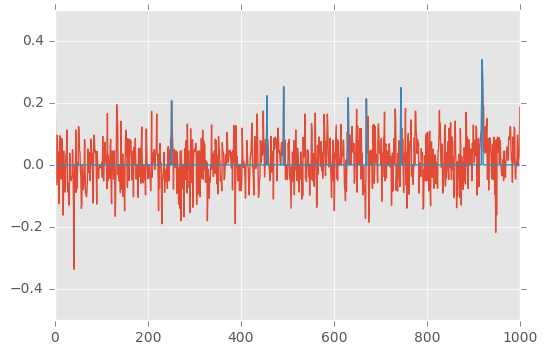

In [22]:
plt.plot(np.sum(pmtcwf[0]*adc_to_pes, axis=0))
plt.plot(np.sum(pmtzs[0]*adc_to_pes, axis=0))
plt.xlim((0,1000))
plt.ylim((-.5,.5))

**The cut for zero suppression is performed over the PMT-summed waveform. Particularly based on the RMS around of the baseline. Therefore, we histogram the rms (measured with the first 500 samples of the waveform) for a bunch of events and study the performance of the cut as the fraction of the distribution left behind. The same is done for the end of the waveform in order to compare the results**

In [5]:
rmss = np.array([[np.std(np.sum(evt*adc_to_pes, axis=0)[i*500:(i+1)*500]) for i in range(64)] for evt in pmtcwf])
rms_begin = rmss[:,0].flatten()
rms_end = rmss[:,-1].flatten()
rms_mean = np.mean(np.array(rmss), axis=0)
rms_rms = np.std(np.array(rmss), axis=0)

In [42]:
samples = np.array([np.sum(evt*adc_to_pes, axis=0)[:500] for evt in pmtcwf[:500]]).flatten()

[  2.09044626e+02  -6.45806979e-03   6.75388152e-02]


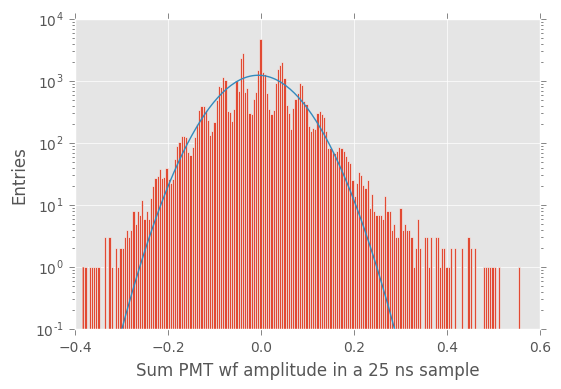

In [43]:
h = plt.hist(samples, 200)
plt.yscale("log")

f, v, e = fit.fit("gauss", h[1][:-1], h[0], (1e5, 0., 0.1))
plt.plot(h[1][:-1], f(h[1][:-1]))
plt.ylim((1e-1, 1e4))
print(v)
plt.xlabel("Sum PMT wf amplitude in a 25 ns sample")
plt.ylabel("Entries")

# CWF

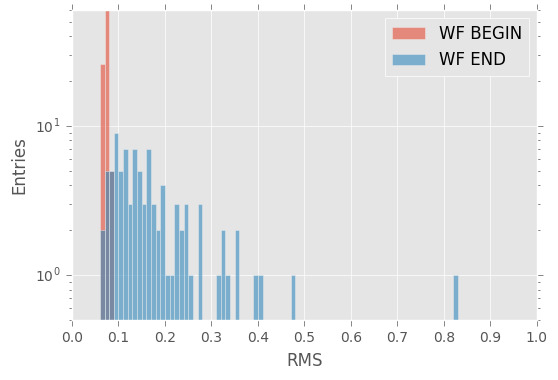

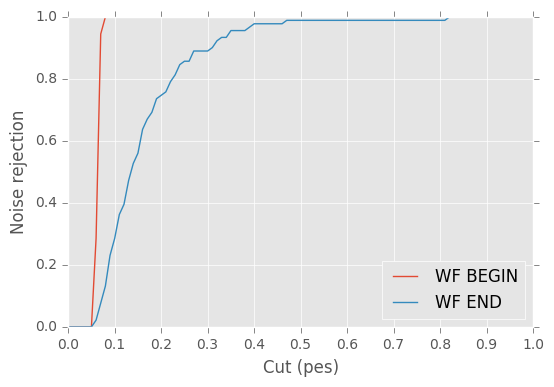

In [6]:
h_begin = plt.hist(rms_begin, 100, range=(0,1), alpha=0.6, label="WF BEGIN")
h_end = plt.hist(rms_end, 100, range=(0,1), alpha=0.6, label="WF END")

plt.xticks(np.linspace(0.,1.,11))
plt.legend()
plt.ylim((0.5, plt.ylim()[1]))
plt.yscale("log")
plt.xlabel("RMS")
plt.ylabel("Entries")
x = h_begin[1][:-1]
y_begin = h_begin[0].cumsum(); y_begin/=1.*y_begin[-1]
y_end = h_end[0].cumsum(); y_end/=1.*y_end[-1]

plt.figure()
plt.plot(x, y_begin, label="WF BEGIN")
plt.plot(x, y_end, label="WF END")
plt.xticks(np.linspace(0.,1.,11))
plt.legend(loc="lower right")
plt.xlabel("Cut (pes)")
plt.ylabel("Noise rejection")

# BLR

In [7]:
rms_begin = [np.std(np.sum(wfm.subtract_baseline(4096-evt)*adc_to_pes, axis=0)[:500]) for evt in pmtblr]
rms_end = [np.std(np.sum(wfm.subtract_baseline(4096-evt)*adc_to_pes, axis=0)[-500:]) for evt in pmtblr]

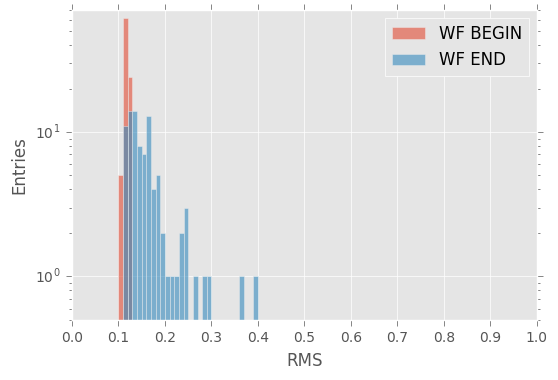

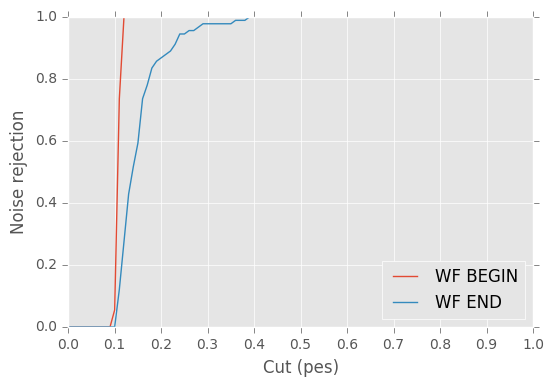

In [8]:
h_begin = plt.hist(rms_begin, 100, range=(0,1), alpha=0.6, label="WF BEGIN")
h_end = plt.hist(rms_end, 100, range=(0,1), alpha=0.6, label="WF END")

plt.xticks(np.linspace(0.,1.,11))
plt.legend()
plt.ylim((0.5, plt.ylim()[1]))
plt.yscale("log")
plt.xlabel("RMS")
plt.ylabel("Entries")
x = h_begin[1][:-1]
y_begin = h_begin[0].cumsum(); y_begin/=1.*y_begin[-1]
y_end = h_end[0].cumsum(); y_end/=1.*y_end[-1]

plt.figure()
plt.plot(x, y_begin, label="WF BEGIN")
plt.plot(x, y_end, label="WF END")
plt.xticks(np.linspace(0.,1.,11))
plt.legend(loc="lower right")
plt.xlabel("Cut (pes)")
plt.ylabel("Noise rejection")

# Study of the accuracy of the RMS vs the slice of the waveform

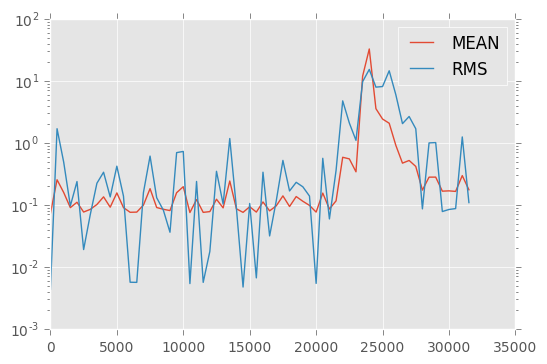

In [10]:
x = np.arange(0,32000,500)

plt.plot(x, rms_mean, label="MEAN")
plt.plot(x, rms_rms, label="RMS")
plt.yscale("log")
plt.legend()